In [1]:
import os
import sys
import torch
from torchvision import transforms

In [2]:
sys.path.append('../')

In [11]:
from src.models.vae import VAE
from src.data.dataset import CityImageDataset
from src.data.invert import Invert
from settings import FIGPATH
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


* Load model

In [5]:
image_channels = 1
model = VAE(image_channels=image_channels, h_dim=1024).to(device)
model.load_state_dict(torch.load('../src/models/vae.torch', map_location='cpu'))   # Start with pretrained model.

In [6]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 1, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)

* Prepare data

In [7]:
datapath = os.path.join(FIGPATH,'figures_20000')

In [8]:
datapath

'../reports/figures/figures_20000'

In [9]:
train_dataset = CityImageDataset(root=os.path.join(datapath,'train'),transform=transforms.Compose([
    transforms.Grayscale(),
    Invert(),
    transforms.CenterCrop(128),    # instead of random crop
    transforms.Resize(64),
    transforms.ToTensor(),
]))
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1
)

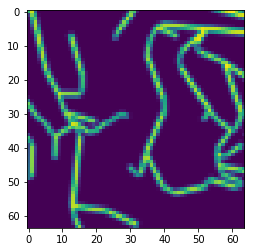

In [12]:
plt.imshow(train_dataset[1][0].view(64,64).numpy())

* Get latent codes

In [41]:
import numpy as np
z_images = np.zeros((848,32))
image_names = []
image_tensors = []
with torch.no_grad():
    for idx, (image, _, image_name) in enumerate(train_loader):
        z_image = model.encode(image)[0].numpy()
        z_images[idx] = z_image
        image_names.append(image_name)
        image_tensors.append(image)

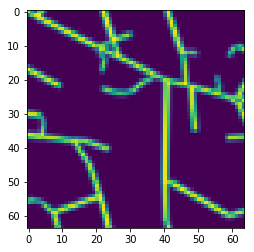

In [31]:
plt.imshow(image.view(64,64).numpy())

* Project latent codes to 2D

In [15]:
from sklearn.manifold import TSNE

In [16]:
z_embedded = TSNE(n_components=2).fit_transform(z_images)

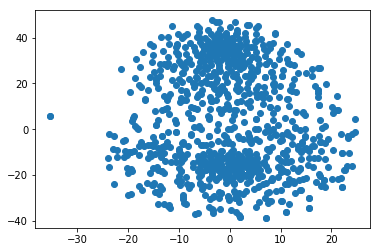

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(z_embedded[:,0],z_embedded[:,1])

* Colour dots by country code

In [18]:
country_codes = []
for img in image_names:
    code = img[0].split('/')[-1].split('_')[0]
    country_codes.append(code)

In [19]:
from collections import Counter

In [20]:
np.unique(country_codes)

array(['AE', 'AF', 'AL', 'AM', 'AO', 'AR', 'AU', 'AZ', 'BD', 'BE', 'BF',
       'BH', 'BI', 'BJ', 'BO', 'BR', 'BY', 'CA', 'CD', 'CF', 'CG', 'CH',
       'CI', 'CL', 'CM', 'CN', 'CO', 'CR', 'CU', 'CZ', 'DE', 'DO', 'DZ',
       'EC', 'EG', 'EL', 'ER', 'ES', 'ET', 'FR', 'GA', 'GE', 'GH', 'GM',
       'GN', 'GT', 'HK', 'HN', 'HR', 'HT', 'ID', 'IE', 'IL', 'IN', 'IQ',
       'IR', 'IT', 'JM', 'JO', 'JP', 'KE', 'KH', 'KP', 'KR', 'KW', 'KZ',
       'LB', 'LK', 'LR', 'LV', 'LY', 'MA', 'MD', 'MG', 'ML', 'MM', 'MN',
       'MR', 'MU', 'MW', 'MX', 'MY', 'MZ', 'NE', 'NG', 'NI', 'NL', 'NO',
       'NP', 'NZ', 'PA', 'PH', 'PK', 'PL', 'PR', 'PS', 'PT', 'PY', 'QA',
       'RO', 'RS', 'RU', 'RW', 'SA', 'SD', 'SG', 'SL', 'SN', 'SO', 'SV',
       'SY', 'TD', 'TG', 'TM', 'TN', 'TR', 'TZ', 'UA', 'UK', 'US', 'UZ',
       'VE', 'VN', 'XH', 'YE', 'ZA', 'ZM', 'ZW'], dtype='<U2')

In [21]:
colour_vals = dict(zip(np.unique(country_codes),range(1,len(np.unique(country_codes))+1)))

In [22]:
colour_codes = [colour_vals[val] for val in country_codes]

In [23]:
colour_codes2 = [1 if val != 54 else 5 for val in colour_codes]

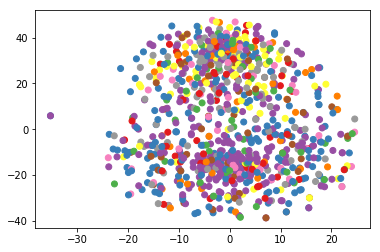

In [24]:
plt.scatter(z_embedded[:,0],z_embedded[:,1], c=colour_codes, cmap='Set1')

* Find closest for each image

In [68]:
import random
from torchvision.utils import save_image
from sklearn.metrics import pairwise_distances
import os

In [83]:
for i in range(0,10):
    
    # Get random index
    idx = random.choice(range(0,len(z_images)))
    
    # Create output folder
    folder_name = image_names[idx][0].split('/')[-1].rstrip('.png')
    folder_path = os.path.join('../reports/figures_closest',folder_name)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        
    # Save orig image
    img_name = '0_'+image_names[idx][0].split('/')[-1]
    save_image(image_tensors[idx].cpu(),os.path.join(folder_path,img_name))
    
    # Get distances
    dists = pairwise_distances(np.array(z_images),z_images[idx].reshape(1,-1))
    dists[idx]=1000
    min_dists = sorted(zip(range(0,len(dists)),dists), key=lambda t: t[1])[0:10]
    
    for i,(idx_min, dist) in enumerate(min_dists):
    
        img_name_closest = str(i+1)+'_'+ image_names[idx_min][0].split('/')[-1]
        save_image(image_tensors[idx_min].cpu(),os.path.join(folder_path,img_name_closest))

In [78]:
min_dists = sorted(zip(range(0,len(dists)),dists), key=lambda t: t[1])

In [80]:
min_dists[0:5]

[(70, array([0.10926306])),
 (323, array([0.11661518])),
 (533, array([0.11848763])),
 (334, array([0.11910185])),
 (662, array([0.1197234]))]

In [76]:
min_dists

[(70, array([0.10926306])),
 (323, array([0.11661518])),
 (533, array([0.11848763])),
 (334, array([0.11910185])),
 (662, array([0.1197234])),
 (151, array([0.11983124])),
 (786, array([0.12034462])),
 (94, array([0.12062204])),
 (19, array([0.1210399])),
 (216, array([0.12196727])),
 (769, array([0.12231256])),
 (722, array([0.1233067])),
 (719, array([0.12358334])),
 (351, array([0.12387964])),
 (148, array([0.12415162])),
 (198, array([0.12422322])),
 (290, array([0.12555627])),
 (228, array([0.12746584])),
 (585, array([0.12770719])),
 (844, array([0.12793742])),
 (300, array([0.13005866])),
 (536, array([0.13031186])),
 (783, array([0.13162665])),
 (439, array([0.13199593])),
 (149, array([0.13216828])),
 (632, array([0.13219111])),
 (16, array([0.13287032])),
 (82, array([0.13337013])),
 (706, array([0.13373809])),
 (5, array([0.13387176])),
 (514, array([0.13390417])),
 (107, array([0.13396393])),
 (245, array([0.13426474])),
 (558, array([0.13447945])),
 (552, array([0.13529253

In [74]:
zip(range(0,len(dists)),dists)

In [67]:
image_names[0][0].split('/')[-1].rstrip('.png')

'CM_1_city_1'

In [42]:
idx = random.choice(range(0,len(z_images)))

In [43]:
print(idx)

467


In [47]:
z_images[0].reshape(1,-1).shape

(1, 32)

In [50]:
np.array(z_images).shape

(848, 32)

In [52]:
# Find closest image
from sklearn.metrics import pairwise_distances

dists = pairwise_distances(np.array(z_images),z_images[idx].reshape(1,-1))

In [57]:
dists[idx]=1000

In [59]:
idx_min = np.argmin(dists)

In [60]:
idx_min

821

In [61]:
save_image(image_tensors[idx].cpu(),'test.png')
save_image(image_tensors[idx_min].cpu(),'test_closest.png')

In [44]:
z_images[idx]

array([-1.2680831 ,  2.03022718, -3.20849895, -1.12733805,  2.58588839,
       -3.22214961, -5.32391882, -4.38645649, -2.95865607,  0.84538496,
       -3.08759069, -3.31504774,  1.83056581, -0.5717259 ,  1.85536098,
        2.43619418, -3.56942344,  0.02367967, -5.38384056,  5.02958822,
       -0.05994517, -1.04160118,  1.34245837, -0.90845788, -0.89204389,
        2.26867151,  6.22152281,  6.31124735,  3.6381135 ,  6.14752293,
        0.14025033, -2.19402814])

In [36]:
Image.open(image_names[355][0]).show()

In [23]:
code

'GH'

In [19]:
image_names[0][0]

'../reports/figures/figures_20000/train/CM_1_city_1.png'

In [87]:
z_image.shape

(1, 32)

In [70]:
images.size()

torch.Size([5, 1, 64, 64])

In [71]:
len(model.encode(images))

3

In [77]:
model.encode(images)[0].numpy()

RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.

In [32]:
train_dataset[0][0]

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0588, 0.2235, 0.4902],
         [0.0000, 0.0000, 0.0000,  ..., 0.6392, 0.8627, 0.9686],
         [0.0000, 0.0000, 0.0000,  ..., 0.9569, 0.9686, 0.9725],
         ...,
         [0.4745, 0.7294, 0.7765,  ..., 0.2706, 0.8784, 0.4157],
         [0.7294, 0.4588, 0.1647,  ..., 0.1608, 0.8667, 0.5529],
         [0.1059, 0.0157, 0.0000,  ..., 0.0980, 0.7961, 0.6706]]])

In [ ]:
for idx, (images, _) in enumerate(train_loader):
    